We are playing 20 questions.

The user (person) thinks about any term, person or object, and the computer (AI) has to guess it by asking up to 20 yes-or-no questions.
You will answer only using yes or no.
If the computer guesses the term in less than 20 questions, it wins.
If the computer does not guess the term in 20 questions, it loses.

The way the computer plays the game is by utilizing the large context window of the newest Gemini model - 2 million tokens! It has access to the full textual content of Wikipedia. That's ~6.5 million documents or approximatelly 6 billion tokens (that's just for the english version).

When asking the first questions, the whole wikipedia dataset still won't fit into the context window, so the computer will use `faiss` to search for the most relevant documents to the question and then use the top documents to ask the next question.

Once the computer can narrow the context fown to ~2 million tokens, it will start using the full context window to ask the following questions.

- Load the wikipedia dataset from https://www.kaggle.com/datasets/jjinho/wikipedia-20230701
- Embed the documents into `faiss` 
- Ask the user to think of something (and not to tell us!)
- Start guessing loop
  - If this is the first round, just ask a random question (ask gemini to propose a good yes\no question to start a game of 20 questions)
  - If this is not the first round, try 


In [2]:
!pip install pandas==1.5.3 numpy==1.23.5 faiss-cpu ipywidgets kagglehub google.generativeai python-dotenv matplotlib pandasai seaborn PyYAML


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
INFO: pip is looking at multiple versions of faiss-cpu to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 11.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 12.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
  Attempting uninstall: faiss-cpu
    Found existing installation: faiss-cpu 1.9.0.post1
    Uninstalling faiss-cpu-1.9.0.post1:
      Successfully uninstalled faiss-cpu-1.9.0.post1


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jrobischon/wikipedia-movie-plots")

print("Path to dataset files:", path)

Path to dataset files: /home/lizozom/.cache/kagglehub/datasets/jrobischon/wikipedia-movie-plots/versions/1


This part creates the faiss index and loads the wikipedia dataset.
No need to run this part, as the faiss index is attached.
The code is here just for context.

In [4]:
import pandas as pd
print(pd.__version__)


# Load the dataset
data_path = f"{path}/wiki_movie_plots_deduped.csv"
df = pd.read_csv(data_path)

# Display the first few rows to understand its structure
print(df.head())


1.5.3
   Release Year                             Title Origin/Ethnicity  \
0          1901            Kansas Saloon Smashers         American   
1          1901     Love by the Light of the Moon         American   
2          1901           The Martyred Presidents         American   
3          1901  Terrible Teddy, the Grizzly King         American   
4          1902            Jack and the Beanstalk         American   

                             Director Cast    Genre  \
0                             Unknown  NaN  unknown   
1                             Unknown  NaN  unknown   
2                             Unknown  NaN  unknown   
3                             Unknown  NaN  unknown   
4  George S. Fleming, Edwin S. Porter  NaN  unknown   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...   
1  https://en.wikipedia.org/wiki/Love_by_the_Ligh...   
2  https://en.wikipedia.org/wiki/The_Martyred_Pre...   
3  https://en.wiki

In [5]:
len(df)

34886

In [ ]:
def count_words(string):
    words = string.split()
    return len(words)

total_characters = 0 
for plot in df['Plot']:
    total_characters += count_words(plot)

total_characters

In [ ]:
# Inspect the structure
print(df.columns)

# Ensure the text column is correctly identified
text_column = "Plot"  # Replace with the actual column name in your dataset

# Calculate total memory usage in bytes
column_total_size = df[text_column].memory_usage(deep=True)

# Convert to megabytes (optional)
total_size_mb = column_total_size / (1024 ** 2)

print(f"Total size of the DataFrame: {total_size_mb} bytes ({total_size_mb:.2f} MB)")

In [ ]:
def generate_question(history, context):
    prompt = f"""
    You are playing 20 Questions. Based on:
    - Question history: {history}
    - Context: {context}
    Ask the most relevant yes/no question.
    """
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}]
    )
    return response["choices"][0]["message"]["content"]

game_state = {"questions": [], "responses": []}
question = generate_question(game_state["questions"], "Wikipedia")


In [ ]:
from ipywidgets import widgets, interact, VBox

def ask_question():
    question = generate_question(game_state["questions"], "Wikipedia context")
    game_state["questions"].append(question)
    return question

def on_submit(change):
    response = input_box.value
    game_state["responses"].append(response)
    indices, distances = search_candidates(" ".join(game_state["questions"]))
    candidates = [chunks[i] for i in indices[0]]
    question_label.value = ask_question()
    input_box.value = ""

question_label = widgets.Label(value="Think of a word. Let’s begin!")
input_box = widgets.Text()
input_box.observe(on_submit, names='value')

display(VBox([question_label, input_box]))


### Define the chat model

In [ ]:
import os
import google.generativeai as genai
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")



genai.configure(api_key=os.environ["GEMINI_API_KEY"])

generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 40,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-1.5-pro",
  generation_config=generation_config,
)

chat_session = model.start_chat(
  history=[
  ]
)


### Clean the data - Remove unknowns

In [ ]:
import numpy as np

cleaned_df = df.replace("unknown", np.nan).dropna()
print(f"Total number of movies after cleaning: {len(cleaned_df)}")

In [ ]:
unique_generes = df["Genre"].unique()
for t in unique_generes:
    print(t)

Replacing 'sci-fi' with 'science fiction'
Replacing 'sci fi' with 'science fiction'
Replacing 'superheros' with 'superhero'
Replacing 'lgbt-themed' with 'lgbt'
Replacing 'world war ii' with 'war'
Replacing 'world war i' with 'war'
Replacing 'martial artss' with 'martial arts'
Replacing 'martial art' with 'martial arts'
Replacing 'animated short' with 'animation'
Replacing 'animated' with 'animation'
Total number of movies after cleaning: 28803


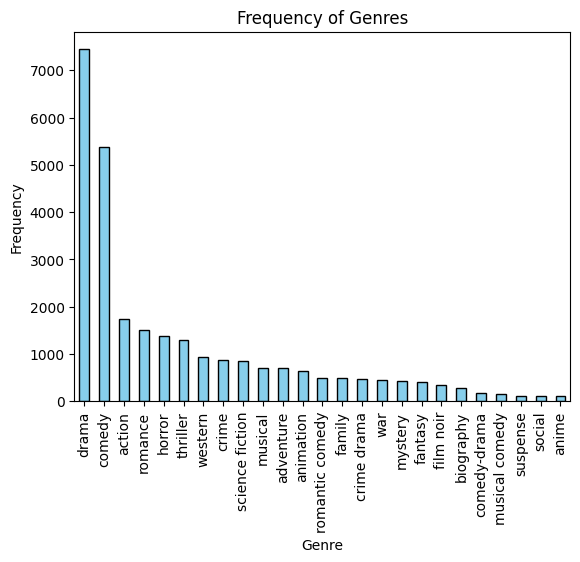

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

SEPARATORS = [
    "–", "-", "/"
]

GENRE_TERM_MAPPING = {
    "sci-fi": "science fiction",
    "sci fi": "science fiction",
    "superheros": "superhero",  
    "lgbt-themed": "lgbt",
    "world war ii": "war",
    "world war i": "war",
    "martial artss": "martial arts",
    "martial art": "martial arts",
    "animated short": "animation",
    "animated": "animation",
}
    
df['Genre_clean'] = df['Genre']

df = df[df['Genre_clean'] != 'unknown']

for term in GENRE_TERM_MAPPING:
    print(f"Replacing '{term}' with '{GENRE_TERM_MAPPING[term]}'")
    df['Genre_clean'] = df['Genre_clean'].str.replace(term, GENRE_TERM_MAPPING[term])
    
# for sep in SEPARATORS:
#     df['Genre_clean'] = df['Genre_clean'].str.replace(sep, ", ", regex=False)

all_genres = df['Genre_clean'].str.split(', ').apply(lambda x: [item.strip() for item in x]).explode()
print(f"Total number of movies after cleaning: {len(df)}")

# Count occurrences of each genre
genre_counts = all_genres.value_counts().head(25)

# print(genre_counts)

# Plot bar chart
genre_counts.plot.bar(color='skyblue', edgecolor='black', title="Frequency of Genres")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.xticks(rotation=90)  # Rotate labels for better visibility
plt.show()

In [72]:

df['Cast_clean'] = df['Cast']
df['Cast_clean'] = df['Cast_clean'].str.replace("\n", ", ", regex=False)



### Create example context prompt

In [73]:
cleaned_df = df
subset_movies = cleaned_df.sample(50)

context_prompt = ""
for idx, line in subset_movies.iterrows():
    cur_prompt = f"""
    Movie id: {idx}
    Movie Name: {line['Title']}
    Release Year: {line['Release Year']}
    Origin/Ethnicity: {line['Origin/Ethnicity']}
    Director: {line["Director"]}
    Cast: {line["Cast"]}
    Genres: {line['Genre_clean']}
    Plot: {line["Plot"]}
    --------------------------------------------------------------------------
    """
    context_prompt += cur_prompt

print(context_prompt[:500])



    Movie id: 21780
    Movie Name: Deadly Companion (Double Negative)
    Release Year: 1982
    Origin/Ethnicity: Canadian
    Director: George Bloomfield
    Cast: John Candy, Anthony Perkins
    Genres: mystery
    Plot: Michael Taylor, played by Michael Sarrazin, is tormented by his sheer lack of memory concerning the night his wife was found brutally killed. Michael's girlfriend Paula (Susan Clark) helps him attempt to make sense of it all. Anthony Perkins plays a blackmailer; Maury Chayk


In [74]:
final_prompt = f"""
You are an Analytical thinker and Pattern recognition expert.
You are given a set of movies, where each is built using the following pattern:

Movie id: unique identifier of each movie.
Movie Name: The name of the movie.
Release Year: Year the movie was released.
Origin/Ethnicity: The ethnicity of the movie.
Director: Full name of the director.
Case: Partial cast names.
Genre: The Genre of the movie.
Plot: The plot of the movie.

Your task is to create a yes no question that divides the movies into two groups. One ground for the answer "yes" and one group for the answer "no".
Aim for questions that cut the number of movies in half.
The question should be short, concise and clear.
It should also be a bit whimsical and fun to engage the players.
The division must be according to one of the following fields: 
    - Movie name
    - Release Year
    - Origin/Ethnicity
    - Director
    - Case
    - Genre
    - Plot

Set of movies: 

{context_prompt}

Return the following:

Yes/no question:
Answer Yes group ids:
Answer No group ids:
"""

In [ ]:
response = chat_session.send_message(final_prompt)
print(response.text)

Next each question needs to be converted to pandas-ai to apply the question condition on the total dataset. 
Repeat the process until all the context fits the model's max context window

In [75]:
import os
from pandasai import SmartDataframe
from pandasai.llm import GoogleGemini


In [76]:

llm = GoogleGemini(os.environ["GEMINI_API_KEY"])
new_df = df[["Title", "Release Year", "Cast", "Plot"]]

smart_df = SmartDataframe(cleaned_df, config={"llm": llm})


In [77]:


smart_df.chat("Get all movies that Julia Robers plays in")

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Genre_clean,Cast_clean
11020,1988,Mystic Pizza,American,Donald Petrie,"Julia Roberts, Annabeth Gish, Lili Taylor, Wil...",comedy,https://en.wikipedia.org/wiki/Mystic_Pizza,The film is about the coming of age of two sis...,comedy,"Julia Roberts, Annabeth Gish, Lili Taylor, Wil..."
11298,1989,Steel Magnolias,American,Herbert Ross,"Sally Field, Dolly Parton, Shirley MacLaine, D...","comedy, drama",https://en.wikipedia.org/wiki/Steel_Magnolias,"Annelle Dupuy, a reserved beauty school gradua...","comedy, drama","Sally Field, Dolly Parton, Shirley MacLaine, D..."
11401,1990,Flatliners,American,Joel Schumacher,"Julia Roberts, Kiefer Sutherland, Kevin Bacon,...",drama,https://en.wikipedia.org/wiki/Flatliners,"Nelson Wright, a medical student, convinces fo...",drama,"Julia Roberts, Kiefer Sutherland, Kevin Bacon,..."
11494,1990,Pretty Woman,American,Garry Marshall,"Julia Roberts, Richard Gere, Héctor Elizondo, ...",romantic comedy,https://en.wikipedia.org/wiki/Pretty_Woman,High-powered businessman Edward Lewis has brok...,romantic comedy,"Julia Roberts, Richard Gere, Héctor Elizondo, ..."
11620,1991,Dying Young,American,Joel Schumacher,"Julia Roberts, Campbell Scott, Vincent D'Onofr...",drama,https://en.wikipedia.org/wiki/Dying_Young,"Hilary O'Neil (Julia Roberts) is a pretty, out...",drama,"Julia Roberts, Campbell Scott, Vincent D'Onofr..."
11646,1991,Hook,American,Steven Spielberg,"Robin Williams, Dustin Hoffman, Julia Roberts,...",adventure,https://en.wikipedia.org/wiki/Hook_(film),Peter Banning is a successful corporate lawyer...,adventure,"Robin Williams, Dustin Hoffman, Julia Roberts,..."
11724,1991,Sleeping with the Enemy,American,Joseph Ruben,"Julia Roberts, Patrick Bergin, Kevin Anderson",thriller,https://en.wikipedia.org/wiki/Sleeping_with_th...,Laura Burney lives in a beautiful home by the ...,thriller,"Julia Roberts, Patrick Bergin, Kevin Anderson"
12048,1993,The Pelican Brief,American,Alan J. Pakula,"Julia Roberts, Denzel Washington, John Lithgow...",thriller,https://en.wikipedia.org/wiki/The_Pelican_Brie...,After two Supreme Court justices are killed by...,thriller,"Julia Roberts, Denzel Washington, John Lithgow..."
12683,1996,Everyone Says I Love You,American,Woody Allen,"Edward Norton, Alan Alda, Woody Allen, Goldie ...",musical comedy,https://en.wikipedia.org/wiki/Everyone_Says_I_...,The emotions of an extended upper-class family...,musical comedy,"Edward Norton, Alan Alda, Woody Allen, Goldie ..."
12774,1996,Mary Reilly,American,Stephen Frears,"Julia Roberts, John Malkovich, Glenn Close",drama,https://en.wikipedia.org/wiki/Mary_Reilly_(film),Mary Reilly comes to work as a maid in the hom...,drama,"Julia Roberts, John Malkovich, Glenn Close"
